# Local Ensemble Transform Kalman Filter

## ----------コードを書く前の下準備----------

### Reference (参考文献)
- Brian R.Hunt Eric, J.Kostelich, Istvan Szunyogh. 2006. Efficient data assimilation for spatiotemporal chaos: A local ensemble transform Kalman filter, https://www.sciencedirect.com/science/article/pii/S0167278906004647.

### Ensemble Kalman Filter (アンサンブルカルマンフィルター)

特徴
- KFでは，平均・共分散行列だけ更新していたが，EnKFでは，アンサンブルメンバー(状態サンプルを幾つも用意しモンテカルロ近似を行う)の更新を考える．
- EnKFでは，非線形・非ガウスにも対応することができる．

対象とする状態空間モデルは，
$$
\begin{align}
x_t=f_t(x_{t-1},v_t),\ v_t\sim q(v_t)\\
y_t=H_tx_t+w_t,\ w_t\sim N(0,R_t)
\end{align}
$$
である．観測モデルに関してはガウス・線形性を仮定するが，非線形の場合でも適切な前処理をすれば適用可能である．

アルゴリズム
1. 初期状態のアンサンブル$\{x_{0|0}^{(i)}\}_{i=1}^N$を生成する．
2. $t=1:T$まで以下を繰り返す．
    1. 一期先予測
        1. システムノイズのアンサンブル$\{v_t^{(i)}\}_{i=1}^N$を$q(v_t)$に従って生成する．
        1. 各アンサンブルメンバーに対して，$x_{t|t-1}^{(i)}=f_t(x_{t-1|t-1}^{(i)},v_t)$を計算する．
    1. フィルタ
        1. 観測ノイズのアンサンブル$\{w_t^{(i)}\}_{i=1}^N$を$N(0,R_t)$に従って生成する．
        1. 共分散行列$\hat V_{t|t-1}$，カルマンゲイン$\hat K_t$を後述する式で計算する．
        1. 各アンサンブルメンバーに対して，$x_{t|t}^{(i)}=x_{t|t-1}^{(i)}+\hat K_t(y_t+\breve w_t^{(i)}-H_tx_{t|t-1}^{(i)})$を計算し，フィルタアンサンブル$\{x_{t|t}^{(i)}\}_{i=1}^N$を得る．

フィルタB.bの計算式は以下の通りである．
$$
\begin{align}
\breve x_{t|t-1}^{(i)}=x_{t|t-1}^{(i)}-\frac{1}{N}\sum_{j=1}^Nx_{t|t-1}^{(j)}\\
\hat V_{t|t-1}=\frac{1}{N-1}\sum_{j=1}^N\breve x_{t|t-1}^{(j)}\breve x_{t|t-1}^{(j)}{}^T\\
\breve w_t^{(i)}=w_t^{(i)}-\frac{1}{N}\sum_{j=1}^Nw_t^{(i)}\\
\hat R_t=\frac{1}{N-1}\sum_{j=1}^N\breve w_t^{(j)}\breve w_t^{(j)}{}^T
\end{align}
$$

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > phase2 > Python_source : saving place for source
- DataAssimilation > phase2 > plot : saving place for plot result

バージョンについて
- Mac OS 10.13
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [1]:
# install packages
from IPython.core.display import display
import time
import math

import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error as MSE

#from letkf import *
from letkf_numba import *

## Lorenz96 で試してみた

Lorenz 96 model は1996年にEdward Lorenzが提案した非線形モデルである．
\\[(\forall i\in\{1,\cdots,N\})\quad\frac{dx_i}{dt}=(x_{i+1}-x_{i-2})x_{i-1}-x_i+F\\]
ここで，周期境界条件$x_{-1}=x_{N-1},x_0=x_N,x_{N+1}=x_1$を採用している．<br>
参照：https://en.wikipedia.org/wiki/Lorenz_96_model

In [2]:
# update
# 1時点update関数
def Lorenz96_update(x, dt, F) :
    '''
    x [n_dim] {numpy-array, float} : state variable
    dt {int} : time resolution
    F [n_dim] {numpy-array, float} : outforcing
    '''
    d = np.zeros_like(x)
    N = len(d)
    
    # first the 3 edge cases : i = 0, 1, N-1
    d[0] = x[0] + dt * ((x[1] - x[N - 2]) * x[N - 1] - x[0])
    d[1] = x[1] + dt * ((x[2] - x[N - 1]) * x[0] - x[1])
    d[N - 1] = x[N - 1] + dt * ((x[0] - x[N - 3]) * x[N - 2] - x[N - 1])
    
    # remain update 2:N-1
    d[2:N-1] = x[2:N-1] + dt * ((x[3:] - x[:N-3]) * x[1:N-2] - x[2:N-1])
    
    #for i in range(2, N - 1) :
    #    d[i] = x[i] + dt * ((x[i + 1] - x[i - 2]) * x[i - 1] - x[i])
    d += dt * F
    return d

# perfect simulation function
def Lorenz96_perfect(initial_mean, last_time, dt, F) :
    '''
    initial_mean [n_dim] {numpy-array, float} : initial mean of x
    last_time {int} : last time for calculation
    dt {float} : time resolution
    F [n_dim] {float} : outforcing each time
    '''
    t = 0
    x = initial_mean
    calculation_last_time = math.ceil(last_time / dt) + 1
    d = np.zeros((calculation_last_time + 1, len(x)))
    d[0] = initial_mean
    
    # update
    for i in range(calculation_last_time) :
        x = Lorenz96_update(x, dt, F)
        d[i + 1] = x
    return d

# perfect simulation function with noise
def Lorenz96_perfect_noise(initial_x, time, dt, F, sigma) :
    '''
    initial_mean [n_dim] {numpy-array, float} : initial mean of x
    last_time {int} : last time for calculation
    dt {float} : time resolution
    F [n_dim] {float} : outforcing
    sigma {float} : standard deviation of normal noise
    '''
    t = 0
    x = initial_mean
    calculation_last_time = math.ceil(last_time / dt) + 1
    d = np.zeros((calculation_last_time + 1, len(x)))
    d[0] = initial_mean
    
    for i in range(calculation_last_time) :
        noise = rd.normal(0, sigma, size = len(x))
        x = Lorenz96_update(x, dt, F) + noise
        d[i + 1] = x
    return d

In [3]:
# parameter
N = 30
n_particle = 10

# sys_sigma, obs_sigma are variance
sys_sigma = 0.027
obs_sigma = 2.615

# make sigma is standard deviation
make_sigma = 0.0001
make_initial_mean = 5.0 * np.ones(N) + rd.normal(0, 1, size = N)
initial_mean = 4.9 * np.ones(N)
sim_initial_mean = 4.9 * np.ones(N) + rd.normal(0, 1, size = N)
initial_sd = 0.01
F = 8
dt = 0.01
last_time = 15.0

In [4]:
# perfect simulation
perf_x = Lorenz96_perfect(make_initial_mean, last_time, dt, F)

# perfect simulation + noise
perf_x_noise = Lorenz96_perfect_noise(make_initial_mean, last_time, dt, F, make_sigma)

In [5]:
# 単純シミュレーション結果の用意
# initial_mean だと単調でつまらないので，sim_initial_mean 使う
sim_x = Lorenz96_perfect(sim_initial_mean, last_time, dt, F)

In [6]:
perf_x[::10]

array([[ 4.31116442,  5.58771175,  3.89710488, ...,  6.43750596,
         3.39186   ,  3.47926099],
       [ 5.5902168 ,  6.35266339,  5.10390548, ...,  6.31556165,
         2.56307048,  3.4471016 ],
       [ 7.48881299,  7.42080703,  4.82390879, ...,  5.41216907,
         1.52541804,  3.94081293],
       ...,
       [ 0.90438579,  5.51601205,  6.85121623, ...,  5.22509636,
        -2.69378215, -0.26211595],
       [ 1.99383096,  6.5094958 ,  6.28565297, ..., -0.40586493,
        -3.05648592,  0.91128252],
       [ 3.30068547,  7.90663643,  5.10026407, ..., -1.31461002,
        -1.98582689,  0.62365512]])

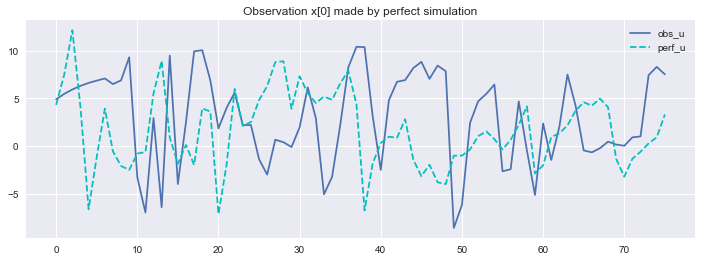

In [7]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(last_time / dt) + 1
time_data = np.linspace(0, last_time, time_step)
obs_x = np.zeros((time_step, N))
obs_x[:, :] = np.nan
obs_x[::time_interval] = perf_x_noise[::time_interval]
plt.figure(figsize = (12, 4))
plt.plot(obs_x[::time_interval, 0], label = 'obs_u')
plt.plot(perf_x[::time_interval, 0], linestyle = '--', color = 'c', label = 'perf_u')
plt.legend(loc = 'upper right')
plt.title("Observation x[0] made by perfect simulation")
plt.show()

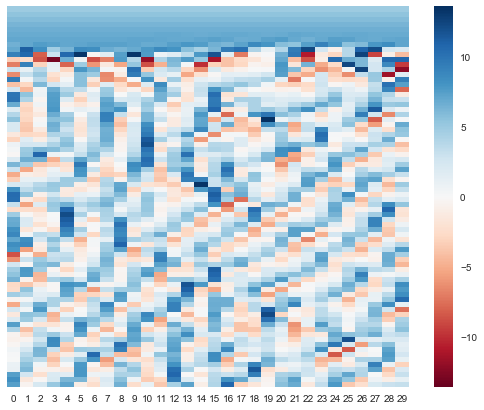

In [8]:
# heat map
plt.figure(figsize = (9,7))
sns.heatmap(data = obs_x[::time_interval], cmap = 'RdBu', yticklabels = False,
           center = 0)
plt.show()

In [9]:
def transition_function(state, noise):
    return Lorenz96_update(state, dt = 0.01, F = 8) + noise

In [10]:
def observation_function(state):
    return state

In [11]:
# observation covariance
R = obs_sigma ** 2 * np.eye(N)

# adjacency matrix
# 五重対角行列
A = np.tri(N, N, 2, int) + np.tri(N, N, 2, int).T - 1

In [12]:
# 単純シミュレーションと実験条件を揃えるため，sim_initial_mean 用いる
letkf = Local_Ensemble_Transform_Kalman_Filter(obs_x,
                                              transition_functions = [transition_function],
                                              initial_mean = sim_initial_mean,
                                              observation_covariance = R,
                                              system_adjacency_matrix = A,
                                              observation_adjacency_matrix = A,
                                              rho = 1.1, n_particle = 10, dtype = np.float16)
letkf.filter()

 filter calculating... t=1/1501

/Users/ev50049/Dropbox/Jupyter/Data_Assimilation/phase2/source/letkf_numba.py:309: ComplexWarning: Casting complex values to real discards the imaginary part
  self.n_dim_sys, self.n_particle, self.rho)


 filter calculating... t=1501/1501

In [13]:
letkf.n_dim_sys, letkf.n_dim_obs, letkf.n_particle

(30, 30, 10)

In [43]:
# 単純シミュレーションと実験条件を揃えるため，sim_initial_mean 用いる
letkf = Local_Ensemble_Transform_Kalman_Filter(obs_x,
                                              transition_functions = [transition_function],
                                              initial_mean = sim_initial_mean,
                                              observation_covariance = R,
                                              system_adjacency_matrix = A,
                                              observation_adjacency_matrix = A,
                                              rho = 1.1, n_particle = 10, dtype = np.float16)
letkf.filter()

 filter calculating... t=21/1501

/Users/ev50049/Dropbox/Jupyter/Data_Assimilation/phase2/source/letkf.py:310: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x_filt[t + 1, i] = analysis_system[len(np.where(self.A_sys[i, :i])[0])]


 filter calculating... t=1501/1501

- 行列の平方根計算で虚部が生じて，虚部を無視して実部だけ残すような処理がされてそう
- プロット見る感じはそんな悪くない

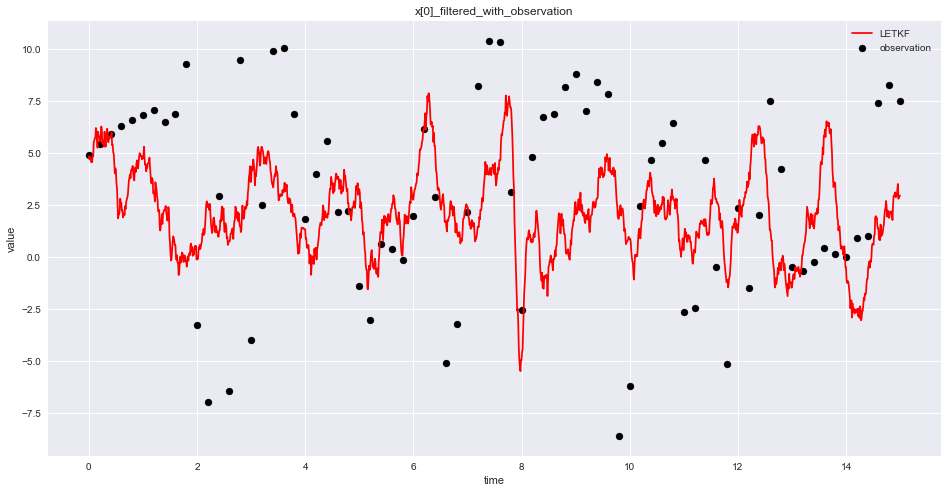

In [13]:
T = len(obs_x)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_x[::time_interval, 0], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, letkf.get_filtered_value(0), color = "r", label = "LETKF")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.ylabel('value')
plt.title("x[0]_filtered_with_observation")
#plt.savefig("../plot/180402_Lorenz96_twin_experiment_PF_x0.png")
plt.show()

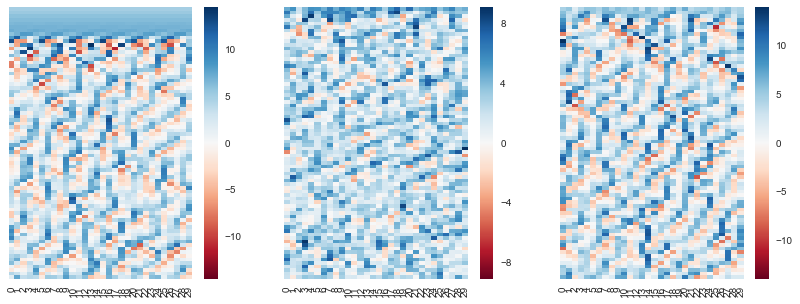

In [44]:
# heat map
plt.figure(figsize = (14, 5))
plt.subplot(1,3,1)
sns.heatmap(obs_x[::time_interval], cmap = 'RdBu', yticklabels = False, center = 0)

plt.subplot(1,3,2)
sns.heatmap(letkf.get_filtered_value()[::time_interval], cmap = 'RdBu', yticklabels = False, center = 0)

plt.subplot(1,3,3)
sns.heatmap(sim_x[::time_interval], cmap = 'RdBu', yticklabels = False, center = 0)
#plt.savefig('../plot/180402_Lorenz96_LETKF_heatmap.png')
plt.show()

誤差プロット

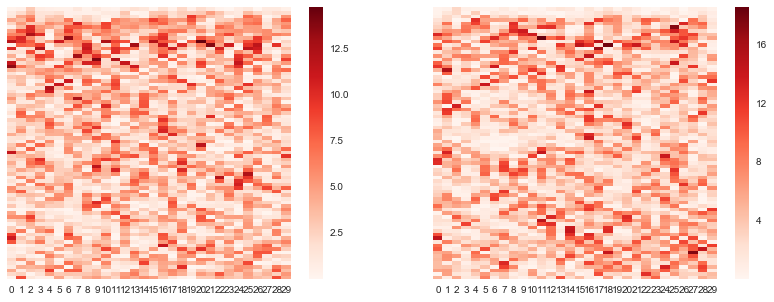

In [45]:
plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
sns.heatmap(np.absolute(letkf.get_filtered_value()[::time_interval] - obs_x[::time_interval]),
            cmap = 'Reds', yticklabels = False)
plt.subplot(1,2,2)
sns.heatmap(np.absolute(sim_x[::time_interval] - obs_x[::time_interval]),
            cmap = 'Reds', yticklabels = False)

MSE誤差で比較

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
error = [[], []]
error[0] = mean_squared_error(letkf.get_filtered_value()[::time_interval], obs_x[::time_interval])
error[1] = mean_squared_error(sim_x[::time_interval], obs_x[::time_interval])
error

[20.293317865112083, 29.851779535585194]

- LETKFの方が単純シミュレーションより誤差が小さいことが見て取れる

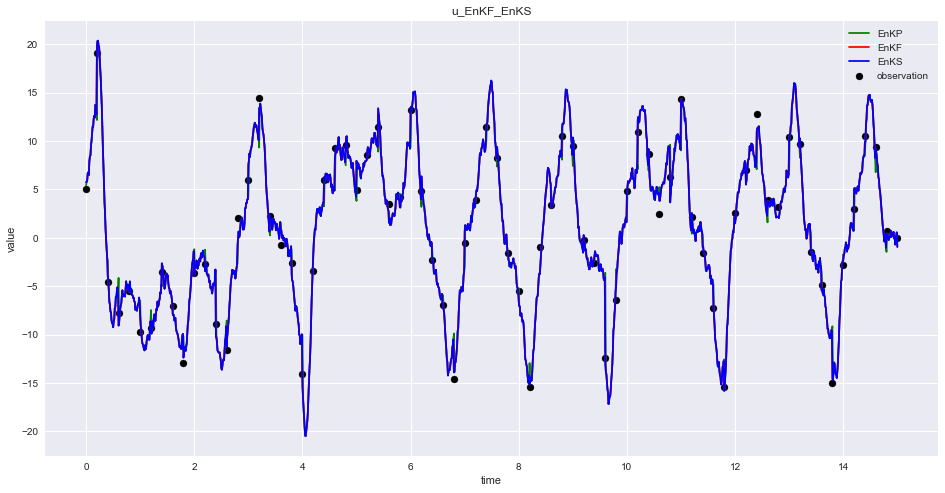

In [13]:
T = len(obs_u)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, ekf.get_predicted_value(0), color = "g", label = "EnKP")
plt.plot(time_data, ekf.get_filtered_value(0), color = "r", label = "EnKF")
plt.plot(time_data, ekf.get_smoothed_value(0), color = "b", label = "EnKS")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_EnKF_EnKS")
#plt.savefig("../plot/180329_twin_experiment_EnKF.png")
plt.show()

- lag 500 取ったが，あまり平滑化されている気配は感じられない
    - 粒子数が足りないせいか，コーディングミスか，固定ラグ平滑化のせいか
- smoothing されていないのは，各時刻に観測があることを前提とした smoothing の式であるからかもしれない

## 通常の時系列で試してみた

In [13]:
df = pd.read_csv('../../data/rhine-river-near-basle-switzerla.csv')

In [14]:
df.head()

,Year,Data
0,1807,864.884
1,1808,1033.141
2,1809,826.923
3,1810,1018.777
4,1811,1118.296


In [15]:
y = np.array(df['Data'])

In [16]:
y /= 1000

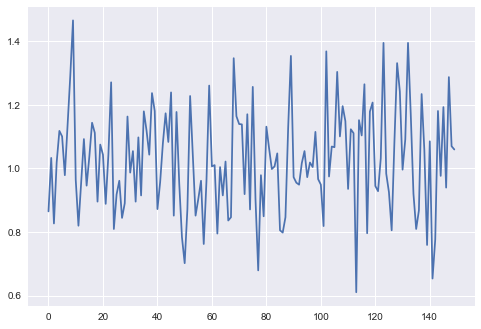

In [17]:
plt.plot(y)

In [18]:
len(y)

150

In [19]:
ekf = Ensemble_Kalman_Filter(y, initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
ekf.smooth(lag = 80)

 smooth calculating... t=150/150

In [19]:
#ekf2 = Ensemble_Kalman_Filter(y, transition_functions = [lambda x,v : 0.9*x+v],  initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
#ekf2.filter()

 filter calculating... t=149/150

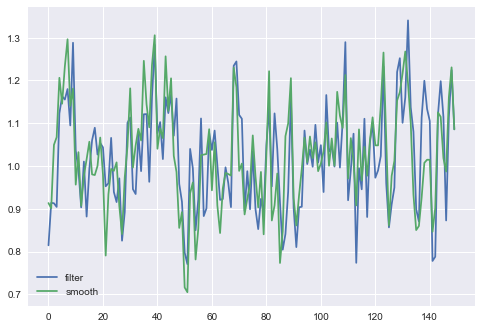

In [20]:
#plt.plot(ekf.get_predicted_value(), label = 'predict')
plt.plot(ekf.get_filtered_value(), label = 'filter')
plt.plot(ekf.get_smoothed_value(), label = 'smooth')
#plt.plot(ekf2.get_filtered_value(), label = 'AR')
#plt.plot(y, label = 'obs')
plt.legend(loc = 'best')

- 状態遷移関数 x+v というランダムウォークな適当な設定なのでまあこんなもん笑
- smooth 感がほんとに感じられない〜

In [11]:
len(np.asarray(ekf.f).shape)

0

色々と改善方針

- カルマンゲイン計算しているのをやめて，Zを計算するように変更？

ノイズ発生計算用

In [7]:
# multivariate_normla は同時に多数発生させられる
rd.multivariate_normal(np.zeros(2), np.eye(2), size = 5)

array([[ 1.41791347,  1.74758099],
       [ 0.48678787,  1.40741448],
       [ 0.01112654,  0.75523378],
       [ 0.08412188, -0.34736737],
       [-0.94864026, -0.65311415]])

enkf の計算簡略用

In [15]:
a = np.arange(1,3)
b = 0.1 * np.arange(1,3)
a * b

array([0.1, 0.4])

In [36]:
np.transpose([a, b], (0,2,1))

array([[[0. , 2. ],
        [1. , 3. ]],

       [[0. , 0.2],
        [0.1, 0.3]]])

In [33]:
np.array([a, b]).transpose(0, 2, 1)

array([[[0. , 2. ],
        [1. , 3. ]],

       [[0. , 0.2],
        [0.1, 0.3]]])

In [31]:
np.concatenate((a, b), axis = 1)

array([[0. , 1. , 0. , 0.1],
       [2. , 3. , 0.2, 0.3]])

In [34]:
def func(a, b):
    return a[1] + b[0]

a = np.arange(4).reshape(2, 2)
b = 0.1 * np.arange(4).reshape(2, 2)
print(func(a[0], b[0]), func(a[1], b[1]))
func(*np.array([a, b]).transpose(0, 2, 1))

1.0 3.2


array([1. , 3.2])

In [22]:
def func(a) : return a+10
len(np.asarray([func]).shape)

1

In [13]:
def func(a) : return a+10
a = np.array([1,2,3])
b = map(func, a)
np.array(list(b))

array([11, 12, 13])

In [21]:
def func(a) : return a+10
vfunc = np.vectorize(func)
a = np.array([1,2,3])
vfunc(a)

array([11, 12, 13])

In [72]:
def func2(a,b) : return a[0]+b[0]
vfunc2 = np.vectorize(func2, signature = '(m,n),(m,n)->(n)')
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[0.1,0.2,0.3], [0.4,0.5,0.6]])
vfunc2(a,b)

array([ 1.1,  2.2,  3.3])

x_pred_mean 計算に際して確認

In [3]:
a = np.arange(1, 4)
1/a

array([1.        , 0.5       , 0.33333333])

In [23]:
a = np.array([[1,2], [3,4]])
np.mean(a)

2.5

In [25]:
np.mean(a, axis = 0), np.mean(a, axis = 1)

(array([ 2.,  3.]), array([ 1.5,  3.5]))

In [26]:
b = np.array([0.1, 0.2])
a-b

array([[ 0.9,  1.8],
       [ 2.9,  3.8]])

In [37]:
np.kron(a, a)

array([[ 1,  2,  2,  4],
       [ 3,  4,  6,  8],
       [ 3,  6,  4,  8],
       [ 9, 12, 12, 16]])

In [38]:
np.vdot(a,a)

30

In [27]:
np.outer(a,a)

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16]])

In [30]:
a

array([[1, 2],
       [3, 4]])

In [29]:
vouter = np.vectorize(np.outer)
vouter(a, a)

array([[ 1,  4],
       [ 9, 16]])

In [34]:
np.tensordot(a, a, axes=1)

array([[ 7, 10],
       [15, 22]])

In [8]:
q[1]

[0, 1]

In [21]:
def func(a, b):
    return a+b
q = (func, [4,1])
q[0](*q[1])

5

なんか計算用

In [4]:
a = np.array([1, 0]).astype(bool)
b = np.arange(4).reshape(2, 2)
b[a]

array([[0, 1]])

In [8]:
a = np.array([1, 1, 0]).astype(bool)
b = np.arange(9).reshape(3, 3)
b[a][:, a]

array([[0, 1],
       [3, 4]])

In [9]:
a = np.array([1, 1, 0]).astype(bool)
b = np.arange(9).reshape(3, 3)
b[0, a]

array([0, 1])

In [15]:
a = np.arange(4).reshape(2,2)
b = 0.1 * np.arange(2)
(a.T + b).T

array([[0. , 1. ],
       [2.1, 3.1]])

In [27]:
a = np.array([0, 1, 1, 0, 1]).astype(bool)
i=4
len(np.where(a[:i])[0])

2

三重対角行列の構成

In [16]:
np.tri(5, 5, 1, int) + np.tri(5, 5, 1, int).T - 1

array([[1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1]])

In [18]:
# 五重対角
np.tri(5, 5, 2, int) + np.tri(5, 5, 2, int).T - 1

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [14]:
a = np.arange(6).reshape(2, 3)
b = np.arange(2)
a + b

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [53]:
a = np.arange(4).reshape(2,2)
b = np.arange(4).reshape(2,2)
for i, aa, bb in zip(range(2), a, b):
    print(aa)

[0 1]
[2 3]
